# Resnet RGB Satellite Image Data
I am trying to get the following logic to work for a resnet:
- Tile RGB satellite image
- Transfer learning pipeline
- Train!
- To output a feature vector

This feature vector will be used as an input into a linear regression model (I think).

In [4]:
import numpy as np
import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.utils import img_to_array
from keras.utils.image_dataset import image_dataset_from_directory

# TODO: Figure out which resnet is the best
from keras.applications import ResNet50V2
from keras.applications.resnet import preprocess_input
from random import randint

# Tile RGB Image
Use [notebook](./tile-satellite-data.ipynb).

# Setup datasets

In [5]:
PATH = '../outputs/tiled-satellite-images-rgb'
SEED = randint(0, 10000)
IMG_SIZE=(256,256)

In [6]:
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    PATH,
    # Reserve 10% for validation; no test option with this function
    validation_split=0.2,
    # Return both train and validation
    subset="both",
    # Random seed for shuffling
    seed=SEED,
    # Labels set to none because unsupervised learning?
    labels=None,
    # Later should batch when more than 32 tiles
    batch_size=None,
    image_size=IMG_SIZE,
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)

Found 5850 files belonging to 1 classes.
Using 4680 files for training.
Using 1170 files for validation.
Number of training samples: 4680
Number of validation samples: 1170


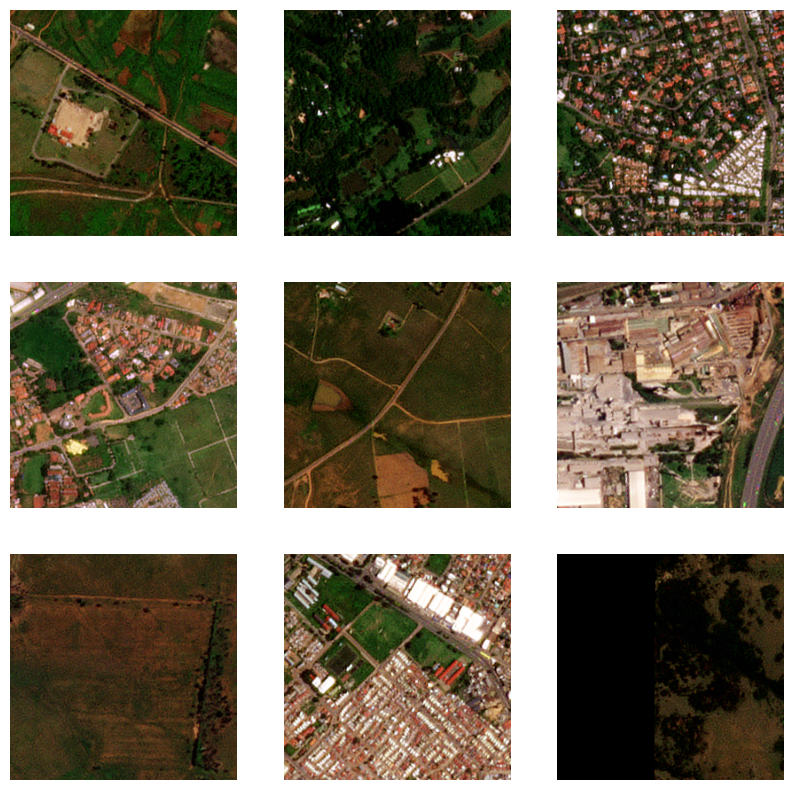

In [7]:
# Plot the first 9 images in training dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i, (image) in enumerate(train_ds.take(9)):
    # Need to do this cast so that images actually show (otherwise get clipping issue)
    image = tf.cast(image, tf.uint8)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

# Standardise data
 - Fixed tile size (this would be handled by my tiling)
 - Normalise pixel values between -1 and 1 ... need to figure this out



In [8]:
# Now batching, caching and prefetching because this apparently optimises loading speeds
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# Data Augmentation
Introducing new samples by applying realistic transformations to training images (e.g. flipping or rotations)
- "exposes the model to different aspects of the training data while slowing down overfitting"

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


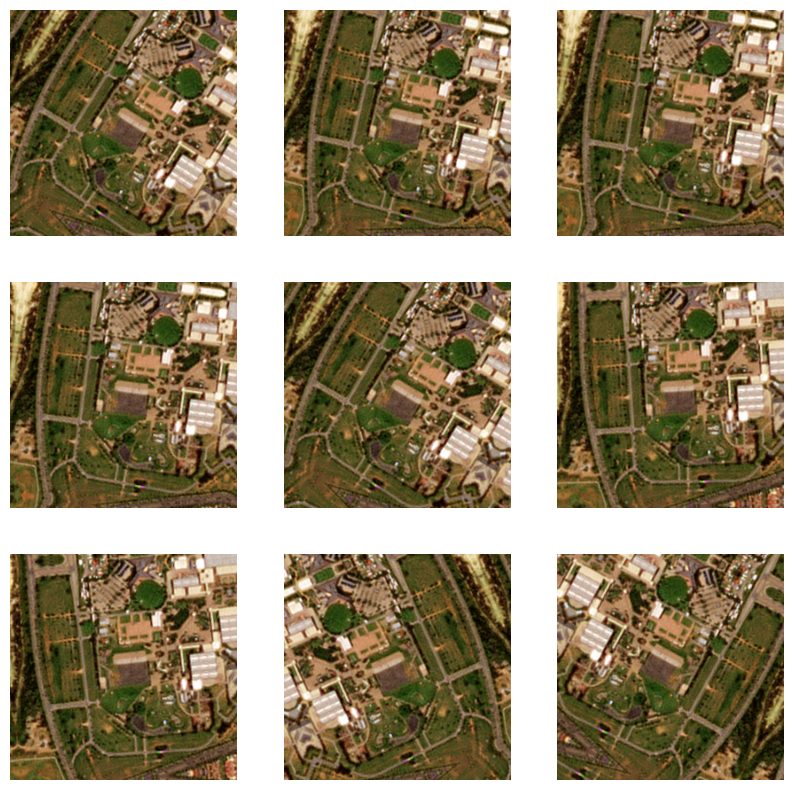

In [10]:
for images in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

# Building Model
The typical transfer-learning workflow is:
1. Instantiate a base model and load pre-trained weights (e.g. from imagenet)
2. Freeze all layers in base model (i.e. weights won't be changed when training input and output layers)
3. Create a new model on top of output of one or several layers from the base model
4. Train "new" model - ie output model - on new dataset

However!!!
In Yeh et al, they used feature extraction. Which has a slightly more lightweight workflow.
1. Instantiate a base model and load pre-trained weights (e.g. from imagenet)
2. Run the new dataset through pre-trained model and record output of one or more layers from base model.
    - This is called **feature extraction**!
3. Use the output features extracted as input into a new, smaller model

For the latter case, there is a major limitation:
- We cannot dynamically modify input data of new model during training - e.g. with data augmentation
This is a limitation because typiccally with a transfer learning workflow, we are using it because the new dataset (e.g. my satellite tiles) has too little data to train a full model from scratch. Therefore, data augmentation is actually really NB.


In [11]:
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Note for above:
# - input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
# TODO: Look more at input_tensor field

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Resnet weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

### Definitions
**batchnorm layer**
- network layer that normalises output of one hidden layer before inputting into next hidden layer

**inference**
Evaluating and predicting (instead of training)

**other**
https://keras.io/getting_started/faq/

# Train top layer
Also, remember that "top" means the output layer!

In [12]:

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

print(train_ds)
print(validation_ds)
epochs = 1
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>
<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


ValueError: in user code:

    File "C:\Users\emily\AppData\Local\pypoetry\Cache\virtualenvs\measuring-quality-of-life-OxfVlamN-py3.10\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\emily\AppData\Local\pypoetry\Cache\virtualenvs\measuring-quality-of-life-OxfVlamN-py3.10\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\emily\AppData\Local\pypoetry\Cache\virtualenvs\measuring-quality-of-life-OxfVlamN-py3.10\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\emily\AppData\Local\pypoetry\Cache\virtualenvs\measuring-quality-of-life-OxfVlamN-py3.10\lib\site-packages\keras\engine\training.py", line 1052, in train_step
        self._validate_target_and_loss(y, loss)
    File "C:\Users\emily\AppData\Local\pypoetry\Cache\virtualenvs\measuring-quality-of-life-OxfVlamN-py3.10\lib\site-packages\keras\engine\training.py", line 1006, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=<keras.losses.MeanSquaredError object at 0x000002079B19D210>, and therefore expects target data to be provided in `fit()`.


# Issues & Questions Thus Far

### Generating validation, train, test
No test option with `keras.utils.image_dataset_from_directory`

### Unsupervised learning
What does this mean?
https://stackoverflow.com/questions/68449103/tf-keras-preprocessing-image-dataset-from-directory-value-error-no-images-found

###  ValueError: Target data is missing. 
Basically, tensorflow expects there to be classification classes. Since there are not, this step is not really working. I've gone down a bit of a 2 month rabit hole to figure out what the issue is here and it is mainly because the fine-tuning I am expecting is not quite the same as what Yeh et al. They seem to do fine tuning with a regression trainer (i.e. already making use of the wealthpooled "labels" at this stage). I am going to now rather make a new notebook and then hopefully soon I am going to rewrite this entire repo.